# Finetuning with MNLI

After finding our best model, follow this notebook to finetune the model with MNLI dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle as pkl
import datetime
import random
import numpy as np
import torch
import os
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import load_data
from models_yi import *
from training_yi import *

In [2]:
DATA_PATH = 'data/'

VOCAB_SIZE = 10000
HIDDEN_DIM = 100
EMBEDDING_DIM = 200
MAX_SENTENCE_LENGTH = 30
BATCH_SIZE = 32
NUM_CLASS = 20
LEARNING_RATE = 0.01
NUM_EPOCHES = 5
CONCAT_MODE = "DIRECT" ## Possible values: "DIRECT", "AVERAGE"

### Initialize MNLI data

In [3]:
mnli_train = pd.read_csv(DATA_PATH + "mnli_train.tsv", sep='\t')
mnli_val = pd.read_csv(DATA_PATH + "mnli_val.tsv", sep='\t')

mnli_train_data = load_data.prepare_data(mnli_train)
mnli_val_data = load_data.prepare_data(mnli_val)
vectors = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'rb'))
id2token = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))

print ("Train dataset size is {}".format(len(mnli_train_data)))
print ("Val dataset size is {}".format(len(mnli_val_data)))
print ("Total number of vocab built from train dataset is {}".format(len(set(id2token))))

Train dataset size is 20000
Val dataset size is 5000
Total number of vocab built from train dataset is 9927


In [4]:
all_genre = mnli_train_data.genre.unique().tolist()
all_genre

['telephone', 'fiction', 'slate', 'government', 'travel']

## Initialize and load our best model (both NN and LR)

In [5]:
PRE_TRAINED = False # model path should be different based on 
                   # whether the vectors are pretrained or not
BEST_LR_MODEL = 'model_lr.pt' ###PLUG IN BEST MODEL HERE
BEST_NN_MODEL = 'model_nn.pt' 

In [6]:
if PRE_TRAINED:
    embed_layer, num_embed, embed_dim = load_data.create_emb_layer(load_data.create_weights(vectors, id2token), 
                                                               non_trainable = True)
if not PRE_TRAINED:
    num_embed = len(id2token)
    embed_dim = EMBEDDING_DIM
    embed_layer = nn.Embedding(num_embed, embed_dim)
    
lr_best_model = LogisticRegression(embed_layer, embed_dim, NUM_CLASS, 'DIRECT')
lr_best_model.load_state_dict(torch.load(BEST_LR_MODEL))

criterion = nn.NLLLoss()
optimizer_lr = optim.Adam(lr_best_model.parameters(), lr = LEARNING_RATE)

In [ ]:
nn_best_model = NeuralNetwork(embed_layer, embed_dim, NUM_CLASS, HIDDEN_DIM, 'DIRECT')
nn_best_model.load_state_dict(torch.load(BEST_NN_MODEL))

criterion = nn.NLLLoss()
optimizer_lr = optim.Adam(nn_best_model.parameters(), lr = LEARNING_RATE)

# 3.2 Evaluating on MultiNLI

In [8]:
def get_data_loaders(genre):
    mnli_train_tel = mnli_train_data[mnli_train_data['genre'] == genre]
    mnli_val_tel = mnli_val_data[mnli_val_data['genre'] == genre]
    indiced_train_data, train_target = load_data.token2index_dataset(mnli_train_tel, token2id)
    indiced_val_data, val_target = load_data.token2index_dataset(mnli_val_tel, token2id)

    train_dataset = load_data.SNLIDataset(indiced_train_data, train_target)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    val_dataset = load_data.SNLIDataset(indiced_val_data, val_target)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    return train_loader, val_loader

In [9]:
model_type = {'lr': lr_best_model, 'nn': None}
df = pd.DataFrame(index=model_type.keys(), columns=all_genre)
for name, model in model_type.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre)
        val_acc = acc(val_loader, model)
        df[genre][name] = val_acc
    break

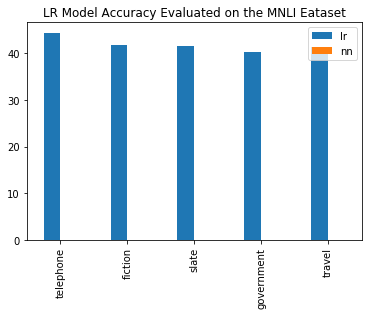

In [12]:
df.T.plot(kind='bar', title='LR Model Accuracy Evaluated on the MNLI Eataset');

In [11]:
df

,telephone,fiction,slate,government,travel
lr,44.3781,41.809,41.6168,40.2559,41.446
nn,NaN,NaN,NaN,NaN,NaN


# 3.3 Fine-tuning on MultiNLI
pick the best model over either NN or LR

In [13]:
best_model = lr_best_model
optimizer = optimizer_lr

**Using `Telephone` below:**

In [14]:
genre = 'telephone'
train_loader, val_loader = get_data_loaders(genre)
train_model(best_model, train_loader, val_loader, 
                     optimizer, criterion, n_epochs=10, save_file=genre+'_model.pt')

Starting epoch 0
End of epoch 1, Training Acc: 54.91803278688525,Validation Acc: 48.35820895522388, Time: 5.760403871536255 sec
New best model found, saving at telephone_model.pt

Starting epoch 1
End of epoch 2, Training Acc: 66.90866510538642,Validation Acc: 45.77114427860697, Time: 11.367899894714355 sec

Starting epoch 2
End of epoch 3, Training Acc: 74.89461358313817,Validation Acc: 44.5771144278607, Time: 17.094571828842163 sec

Starting epoch 3
End of epoch 4, Training Acc: 82.29508196721312,Validation Acc: 43.582089552238806, Time: 23.727601766586304 sec

Starting epoch 4
End of epoch 5, Training Acc: 87.18969555035129,Validation Acc: 44.17910447761194, Time: 31.104445934295654 sec

Starting epoch 5
End of epoch 6, Training Acc: 88.4543325526932,Validation Acc: 43.88059701492537, Time: 37.42482089996338 sec

Starting epoch 6
End of epoch 7, Training Acc: 90.72599531615926,Validation Acc: 43.38308457711443, Time: 43.70764374732971 sec

Starting epoch 7
End of epoch 8, Training A

(LogisticRegression(
   (embed): Embedding(9927, 200)
   (linear): Linear(in_features=400, out_features=20, bias=True)
 ), 92.9976580796253, 41.492537313432834)